<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# LightGBM: A Highly Efficient Gradient Boosting Decision Tree
This notebook gives an example of how to train a LightGBM model to generate point forecasts of product sales in retail. We will train a LightGBM based model on the OrangeJuice dataset.

[LightGBM](https://github.com/Microsoft/LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages:
* Fast training speed and high efficiency.
* Low memory usage.
* Great accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

## Global Settings and Imports

In [18]:
import os
import sys
import math

# import itertools
import datetime
import random
import numpy as np
import pandas as pd
import lightgbm as lgb

# from sklearn.model_selection import train_test_split

# import warnings
# warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("LightGBM version: {}".format(lgb.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
LightGBM version: 2.3.1


In [3]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(nb_dir))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

from forecasting_lib.evaluation.evaluation_utils import MAPE
import forecasting_lib.dataset.retail.benchmark_settings as bs

In [4]:
# Data paths
DATA_DIR = "../../contrib/tsperf/OrangeJuice_Pt_3Weeks_Weekly/data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Parameters of GBM model
params = {
    "objective": "mape",
    "num_leaves": 124,
    "min_data_in_leaf": 340,
    "learning_rate": 0.1,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.87,
    "bagging_freq": 19,
    "num_rounds": 940,
    "early_stopping_rounds": 125,
    "num_threads": 16,
    "verbose_eval": 20,
    "seed": 1,
}

# Lags and categorical features
lags = np.arange(2, 20)
window_size = 40
used_columns = ["store", "brand", "week", "week_of_month", "month", "deal", "feat", "move", "price", "price_ratio"]
categ_fea = ["store", "brand", "deal"]

In [5]:
# Utility functions
def week_of_month(dt):
    """Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """
    from math import ceil

    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom / 7.0))
    return wom


def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product

    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df


def lagged_features(df, lags):
    """Create lagged features based on time series data.
    
    Args:
        df (Dataframe): Input time series data sorted by time
        lags (List): Lag lengths
        
    Returns:
        fea (Dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + "_lag" + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea


def moving_averages(df, start_step, window_size=None):
    """Compute averages of every feature over moving time windows.
    
    Args:
        df (Dataframe): Input features as a dataframe
        start_step (Integer): Starting time step of rolling mean
        window_size (Integer): Windows size of rolling mean
    
    Returns:
        fea (Dataframe): Dataframe consisting of the moving averages
    """
    if window_size is None:  # Use a large window to compute average over all historical data
        window_size = df.shape[0]
    fea = df.shift(start_step).rolling(min_periods=1, center=False, window=window_size).mean()
    fea.columns = fea.columns + "_mean"
    return fea


def combine_features(df, lag_fea, lags, window_size, used_columns):
    """Combine different features for a certain store-brand.
    
    Args:
        df (Dataframe): Time series data of a certain store-brand
        lag_fea (List): A list of column names for creating lagged features
        lags (Numpy Array): Numpy array including all the lags
        window_size (Integer): Windows size of rolling mean
        used_columns (List): A list of names of columns used in model training (including target variable)
    
    Returns:
        fea_all (Dataframe): Dataframe including all features for the specific store-brand
    """
    lagged_fea = lagged_features(df[lag_fea], lags)
    moving_avg = moving_averages(df[lag_fea], 2, window_size)
    fea_all = pd.concat([df[used_columns], lagged_fea, moving_avg], axis=1)
    return fea_all


def make_predictions(df, model):
    """Predict sales with the trained GBM model.
    
    Args: 
        df (Dataframe): Dataframe including all needed features
        model (Model): Trained GBM model
        
    Returns:
        Dataframe including the predicted sales of a certain store and brand
    """
    predictions = pd.DataFrame({"move": model.predict(df.drop("move", axis=1))})
    predictions["move"] = predictions["move"].apply(lambda x: round(x))
    return pd.concat([df[["brand", "store", "week"]].reset_index(drop=True), predictions], axis=1)


def evaluate(result):
    """Compute MAPE value of the forecast.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
    
    Returns:
        MAPE value of the forecast
    """
    return MAPE(result["move"], result["actual"]) * 100


def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store == store) & (results.brand == brand)]
    subset = subset[["week", "move", "actual"]].set_index("week")
    print("Sample MAPE is {}".format(evaluate(subset)))
    ax = subset.plot()
    ax.set_title("Forecast result of brand {} at store {}".format(brand, store))
    ax.set_ylabel("unit sales")
    ax.set_ylim(bottom=0)
    ax.legend(labels=["predicted", "actual"])

In [6]:
# Train and predict for all forecast rounds
pred_all = []
combined_all = []
metric_all = []
for r in range(bs.NUM_ROUNDS):
    print("---- Round " + str(r + 1) + " ----")
    # Load training data
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, "train_round_" + str(r + 1) + ".csv"))
    train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
    print(train_df.head(3))
    print("")
    train_df = train_df[["store", "brand", "week", "move"]]

    # Create a dataframe to hold all necessary data
    store_list = train_df["store"].unique()
    brand_list = train_df["brand"].unique()
    week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r] + 1)
    d = {"store": store_list, "brand": brand_list, "week": week_list}
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how="left", on=["store", "brand", "week"])

    # Get future price, deal, and advertisement info
    aux_df = pd.read_csv(os.path.join(TRAIN_DIR, "aux_round_" + str(r + 1) + ".csv"))
    data_filled = pd.merge(data_filled, aux_df, how="left", on=["store", "brand", "week"])

    # Create relative price feature
    price_cols = [
        "price1",
        "price2",
        "price3",
        "price4",
        "price5",
        "price6",
        "price7",
        "price8",
        "price9",
        "price10",
        "price11",
    ]
    data_filled["price"] = data_filled.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
    data_filled["avg_price"] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
    data_filled["price_ratio"] = data_filled["price"] / data_filled["avg_price"]
    data_filled.drop(price_cols, axis=1, inplace=True)

    # Fill missing values
    print("Number of missing rows is {}".format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    print("")
    data_filled = data_filled.groupby(["store", "brand"]).apply(
        lambda x: x.fillna(method="ffill").fillna(method="bfill")
    )

    # Create datetime features
    data_filled["week_start"] = data_filled["week"].apply(
        lambda x: bs.FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7)
    )
    data_filled["year"] = data_filled["week_start"].apply(lambda x: x.year)
    data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
    data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
    data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
    data_filled.drop("week_start", axis=1, inplace=True)

    # Create other features (lagged features, moving averages, etc.)
    features = data_filled.groupby(["store", "brand"]).apply(
        lambda x: combine_features(x, ["move"], lags, window_size, used_columns)
    )
    train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
    print("Maximum training week number is {}".format(max(train_fea["week"])))
    print("")

    # Drop rows with NaN values
    train_fea.dropna(inplace=True)
    print(train_fea.head(1))
    print("")

    print("Training and predicting models...")
    # Create training set
    dtrain = lgb.Dataset(train_fea.drop("move", axis=1, inplace=False), label=train_fea["move"])
    if r % 3 == 0:
        # Train GBM model
        print("Training model...")
        bst = lgb.train(params, dtrain, valid_sets=[dtrain], categorical_feature=categ_fea, verbose_eval=False)

    # Generate forecasts
    test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    pred = make_predictions(test_fea, bst).sort_values(by=["store", "brand", "week"]).reset_index(drop=True)
    # Additional columns required by the submission format
    pred["round"] = r + 1
    pred["weeks_ahead"] = pred["week"] - bs.TRAIN_END_WEEK_LIST[r]
    print(pred)
    print("")

    # Evaluate prediction accuracy
    test_df = pd.read_csv(os.path.join(TEST_DIR, "test_round_" + str(r + 1) + ".csv"))
    test_df["actual"] = test_df["logmove"].apply(lambda x: round(math.exp(x)))
    test_df.drop("logmove", axis=1, inplace=True)
    combined = pd.merge(pred, test_df, on=["store", "brand", "week"], how="left")
    metric_value = evaluate(combined)
    print("")
    print("MAPE of current round is {}".format(metric_value))
    print("")

    # Keep the predictions and accuracy
    pred_all.append(pred)
    combined_all.append(combined)
    metric_all.append(metric_value)

0   0.0  30.000000  3840  

Number of missing rows is 6237

Maximum training week number is 139

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  8384.0  0.055625   

    price_ratio  ...  move_lag11  move_lag12  move_lag13  move_lag14  \
19     1.279808  ...      8000.0      3840.0      6144.0      8256.0   

    move_lag15  move_lag16  move_lag17  move_lag18  move_lag19    move_mean  
19      8256.0      8256.0      8256.0      8256.0      8256.0  7847.111111  

[1 rows x 29 columns]

Training and predicting models...
      brand  store  week   move  round  weeks_ahead
0         1      2   141   8688      3            2
1         1      2   142   8396      3            3
2         2      2   141   7870      3            2
3         2      2   142   8500      3            3
4         3      2   141   2127      3            2
...     ...    ...   ...    ...    ...          ...
1821      9    137   14

In [7]:
np.mean(metric_all)

35.99143837877612

In [14]:
# import matplotlib.pyplot as plt
#%matplotlib inline

# print('Plot feature importances...')
# ax = lgb.plot_importance(bst, max_num_features=20)
# plt.show()

Sample MAPE is 18.817411697779765
Sample MAPE is 26.64311720009463
Sample MAPE is 18.0322294399468
Sample MAPE is 36.97155019246966
Sample MAPE is 60.60093613767933


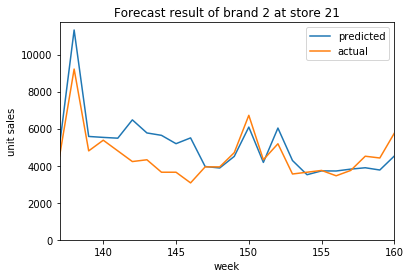

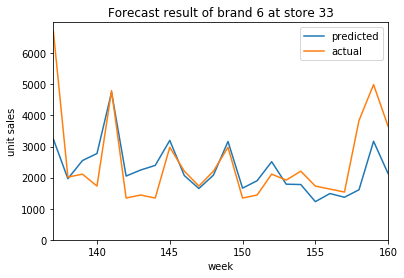

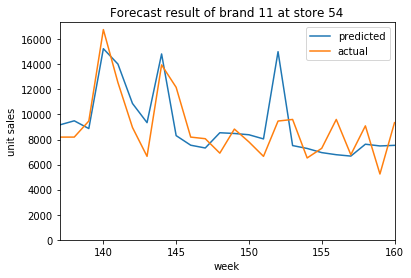

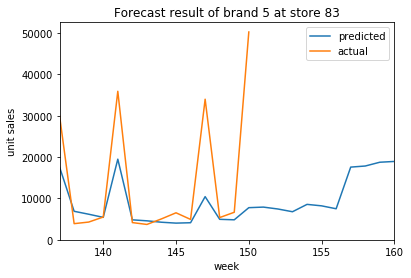

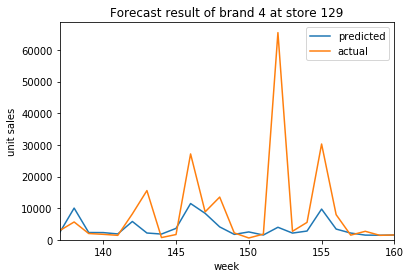

In [15]:
# Visualize forecast results
results = pd.concat(combined_all, axis=0)
random.seed(2)
for _ in range(5):
    store = random.choice(results["store"].unique())
    brand = random.choice(results["brand"].unique())
    plot_result(results, store, brand)